In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats
import timeit
from numpy import linalg as la 
from scipy import interpolate
from random import sample

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from mpl_toolkits import mplot3d
from sklearn.neighbors import BallTree

In [2]:
def sphere_CSR(intensity, r = 1):
    """
    This generate a poisson process with a specified intensity on the surface of a 
    sphere (default with radius 1) and return an array of simulating points.
    
    Parameters
    ----------
    intensity: intensity of the process
    r: radius of the sphere (dafault value is 1)
    
    Reference:
    ----------
    Blog link: hpaulkeeler.com/simulating-a-poisson-point-process-on-a-sphere/
    Author: H. Paul Keeler, 2020.
    Based on: github.com/hpaulkeeler/posts

    """
    totalArea = 4 * np.pi * r ** 2;  # area of sphere

    # Simulate Poisson point process
    numPoints = np.random.poisson(intensity * totalArea);  # Poisson number of points
    #print ("Total number of points: "); print (numPoints)

    randPoints = np.random.normal(0,1,size = (numPoints,3)); #generate standard Gaussian random points

    # Normalize and scale the random points
    normRand = la.norm(randPoints,2,1); #Euclidean norms
    randPoints_sphere = r * randPoints / normRand[:,None]; #rescale by Euclidean norm
    
    return randPoints_sphere

def plot_in_cartesian(data):
    """
    This plot the 3D plot of the data points 
    with cartesian coordinates, (x, y, z)
    
    Parameters
    ----------
    data: data points in cartesian coordiantes (x, y, z)

    """
    #retrieve x, y, and z coordinates
    xx = data[:,0];
    yy = data[:,1];
    zz = data[:,2];

    # Plotting 
    fig = plt.figure(figsize = (40,40))
    plot = fig.add_subplot(111, projection = '3d')
    plot.scatter(xx,yy,zz, c = 'dodgerblue',marker = 'o', s = 50)
    
def to_spherical(cartesian_points):
    """
    Convert an array of points in cartesian coordinates 
    to an array of points in spherical coordinates (in radian).
    This conversion is for the ballTree's input as it only requires
    [latitude, longtitude] without the radius entry.
    
    Parameters
    ----------
    
    cartesian_points : float []
        an array that contain points in spherical coordinates, 
        all points are in the format [x, y, z]
    
    Returns
    -------
    
    points: float []
        an array of spherical coordinates (in radian) in the 
        format [theta, phi], or [latitude, longtitude].
    """
    
    points = []
    
    for i in range(len(cartesian_points)):
        x = cartesian_points[i][0]
        y = cartesian_points[i][1]
        z = cartesian_points[i][2]
        
        if (x==0 and y==0 and z==0):
            points.append([0, 0, 0])
            continue
    
        r = np.sqrt(x*x + y*y + z*z)
        theta = np.arccos(z/r) * 180 / np.pi
        phi = np.arctan2(y,x) * 180/ np.pi
    
        if (theta >= 90):
            theta = 90 - theta
        else:
            theta = 90 - theta
        
        if (phi < 0):
            phi = 360 + phi
            
        points.append([round(np.radians(theta), 6), round(np.radians(phi), 6)])
        
    return points

def cdf_vol_knn(vol):
    """
    Computes an interpolating function to evaluate CDF 
    at a given radius.
    
    Parameters
    ----------
    
    vol: float[:,:]
        List of nearest neighbor distances for each kNN. With each row array represent
        all kNN distances for a specific query points, and the column lenghth is the 
        number of nearest neighbor measured for. 
        
        vol.shape[0] should be # of query points
        vol.shape[1] should be # of kNN measured for each query point.
    
    Returns
    -------
    
    cdf: scipy interpolating function for each kNN, .
         where cdf[k] means the one for kNN-CDF
         
    Reference:
    ----------
    Github link: https://github.com/arkabanerjee/icecube_knn/blob/main/knn.ipynb
    Author: Arka Banerjee, 2022.
    
    """
    
    cdf = []
    n = vol.shape[0]
    l = vol.shape[1]
  
    gof = ((np.arange(0, n) + 1) / (n*1.0)) # evenly spaced values with # = total number of points
    for c in range(l):
        ind = np.argsort(vol[:, c]) # sort the cNN distances for all query points
        s_vol= vol[ind, c] # a sorted array of cNN distances for all query points
        
        # calculating the interplolating function
        cdf.append(interpolate.interp1d(s_vol, gof, kind='linear', 
                                        bounds_error=False))
    return cdf


def kNN_CDFs(datapoints, querypoints):
    """
    This is a helper function that compute the 1NN and 2NN
    distances of the given data points in sperical coodinates (in radian)
    with the format of [theta, phi], or [latitude, longtitude](in radian)
    
    
    Returns
    -------
    
    nearest_1, nearest_2: respectively the computed 
    1NN and 2NN distances
    
    """
    start = timeit.default_timer()

    # Nearest neighbor search with ball tree for the IceCube data
    ballTree = BallTree(datapoints, metric = "haversine", leaf_size=1)
    dist, ind = ballTree.query(querypoints, k = 2) 

    stop = timeit.default_timer()

    print('Time for computation: ', stop - start) 

    nearest_1 = []
    nearest_2 = []
    
    # extract nearesr neighbors from each point's distances array
    for i in range(len(querypoints)):
        nearest_1.append(dist[i][0])
    
    for i in range(len(querypoints)):
        nearest_2.append(dist[i][1])
        
    return nearest_1, nearest_2

The sample size of the reference points: 12597
Plot for the reference points: 


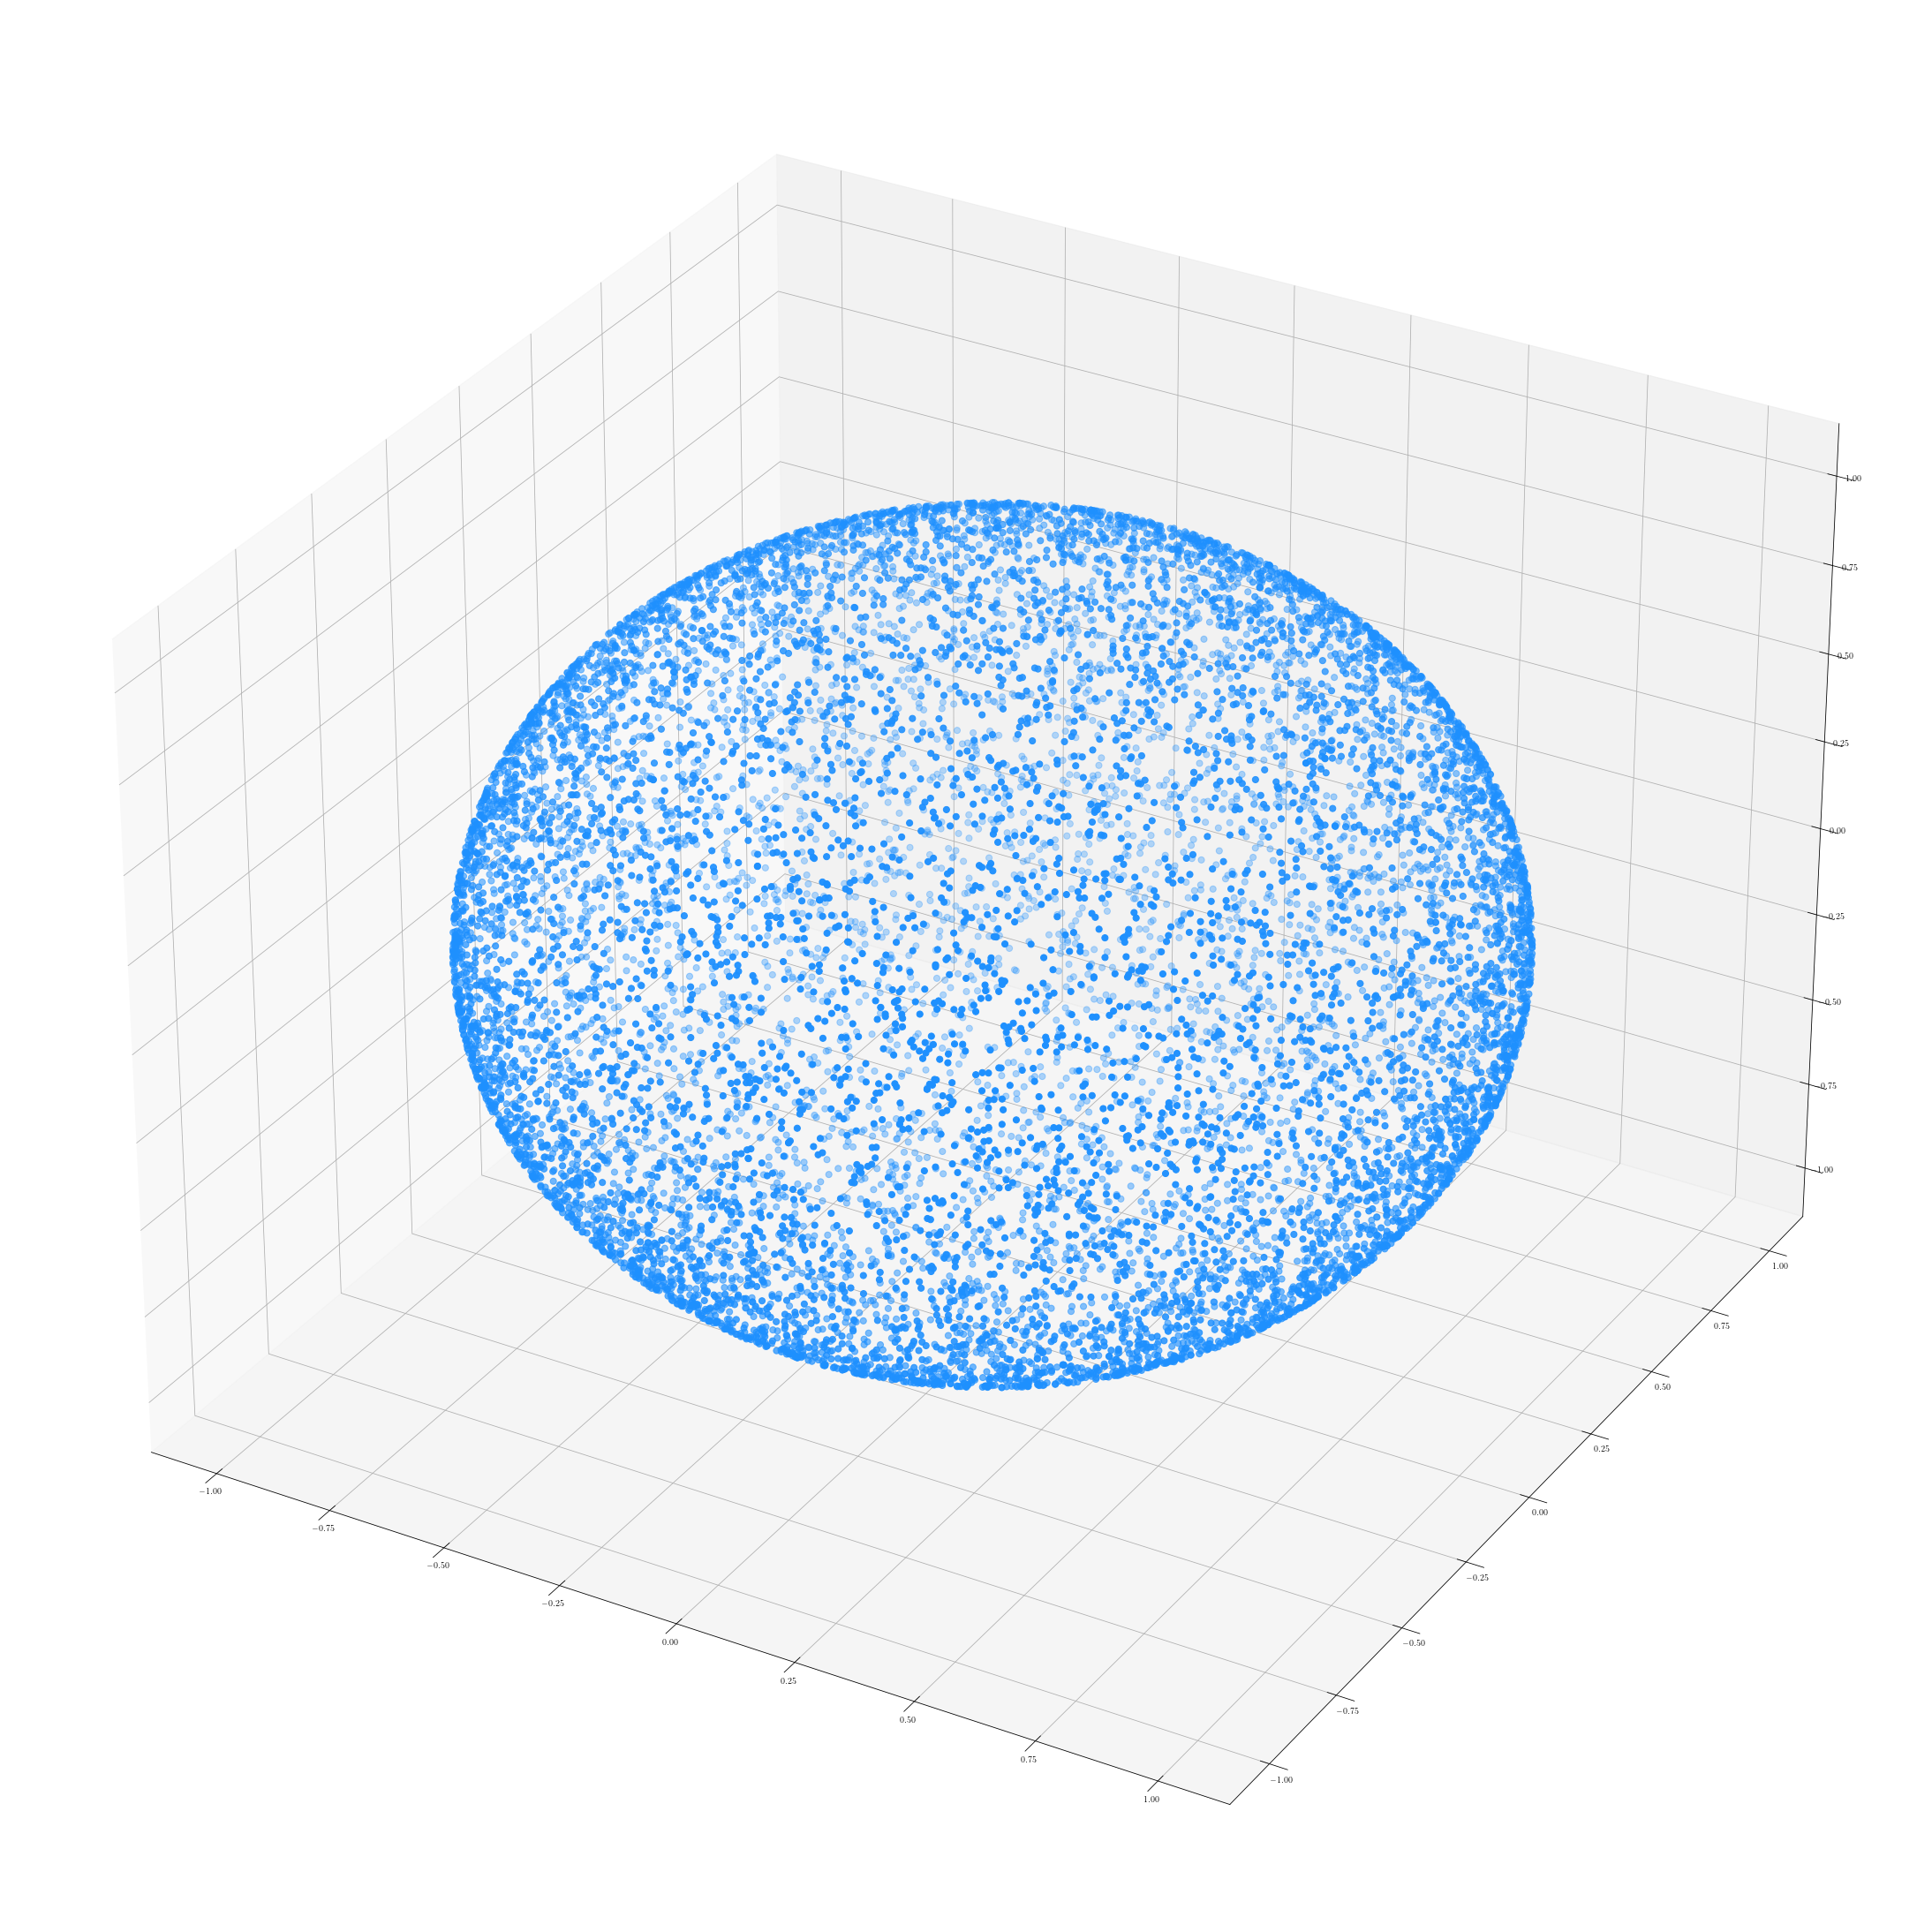

In [3]:
# generate the CSR (Complete spatial randomness) query points and plotting
query_points = sphere_CSR(1000, r = 1)
plot_in_cartesian(query_points)
print (f'The sample size of the reference points: {len(query_points)}')
print ("Plot for the reference points: ")

# generating the first group of CSR points and plotting
CSR_1 = sphere_CSR(500, r = 1)

# obtain 2 subsamples (size = 3000) from the first CSR data 
# these two subsamples should have high cross-correlation as they are sampled from the same dataset
CSR_1_subsample_1 = np.array(sample(CSR_1.tolist(), 3000))
CSR_1_subsample_2 = np.array(sample(CSR_1.tolist(), 3000))


# generate a new group of CSR data points
# this group should be uncorrelated with the above two subsamples
CSR_2 = np.array(sample(sphere_CSR(500, r = 1).tolist(), 3000))

In [4]:
# converting all data samples to spherical coordinates
query_points = to_spherical(query_points)
CSR_1_subsample_1 = to_spherical(CSR_1_subsample_1)
CSR_1_subsample_2 = to_spherical(CSR_1_subsample_2)
CSR_2 = to_spherical(CSR_2)

# kNN searching with ball tree on the CSR_subsample_1 sample
ballTree_1 = BallTree(CSR_1_subsample_1, metric = "haversine", leaf_size=1)
dist_1, ind = ballTree_1.query(query_points, k = 4) 

# kNN searching with ball tree on the CSR_subsample_2 sample
ballTree_2 = BallTree(CSR_1_subsample_2, metric = "haversine", leaf_size=1)
dist_2, ind = ballTree_2.query(query_points, k = 4) 

# kNN searching with ball tree on the CSR_2 sample (uncorrelated with previous two samples)
ballTree_3 = BallTree(CSR_2, metric = "haversine", leaf_size=1)
dist_3, ind = ballTree_3.query(query_points, k = 4) 

In [5]:
# creating the joint kNN distances
dist_correlated = np.maximum(dist_1, dist_2) # between the correlated samples
dist_uncorrelated = np.maximum(dist_1, dist_3) # between uncorrelated samples

# obtain the interpolating functions of the joint kNN-CDFs based on joint kNN distances
# cdf_correlated [0], [1], [2], [3] respectively represents the interpolating function 
# for the first four kNN-CDFs
cdf_correlated = cdf_vol_knn(dist_correlated)
cdf_uncorrelated = cdf_vol_knn(dist_uncorrelated)

# calculating the interpolatig functions for individual kNN-CDFS  of the three datasets 
cdf_1 = cdf_vol_knn(dist_1)
cdf_2 = cdf_vol_knn(dist_2)
cdf_3 = cdf_vol_knn(dist_3)

In [6]:
# generating evenly spaces interval between the minimum and maximum value
# of the kNN distances for the uncorrelated case. However, in the paper, we use
# the 5th and 95th quantile
binc = np.linspace(np.min(dist_uncorrelated), np.max(dist_uncorrelated), 50)
       
# computing CDFs with interpolating function with the generated linear bins
correlated_1NN = cdf_correlated[0](binc) 
uncorrelated_1NN =  cdf_uncorrelated[0](binc)

correlated_2NN = cdf_correlated[1](binc) 
uncorrelated_2NN = cdf_uncorrelated[1](binc) 

# computing the cross-correlation for both correlated and uncorrelated joint kNN-CDFs
# the cross correlation is defined to be: joint kNN-CDF - (product of two seperate kNN-CDFs)
cross_correlated_1NN = cdf_correlated[0](binc) - cdf_1[0](binc) * cdf_2[0](binc)
cross_uncorrelated_1NN = cdf_uncorrelated[0](binc) - cdf_1[0](binc) * cdf_3[0](binc)

cross_correlated_2NN = cdf_correlated[1](binc) - cdf_1[1](binc) * cdf_2[1](binc)
cross_uncorrelated_2NN = cdf_uncorrelated[1](binc) - cdf_1[1](binc) * cdf_3[1](binc)

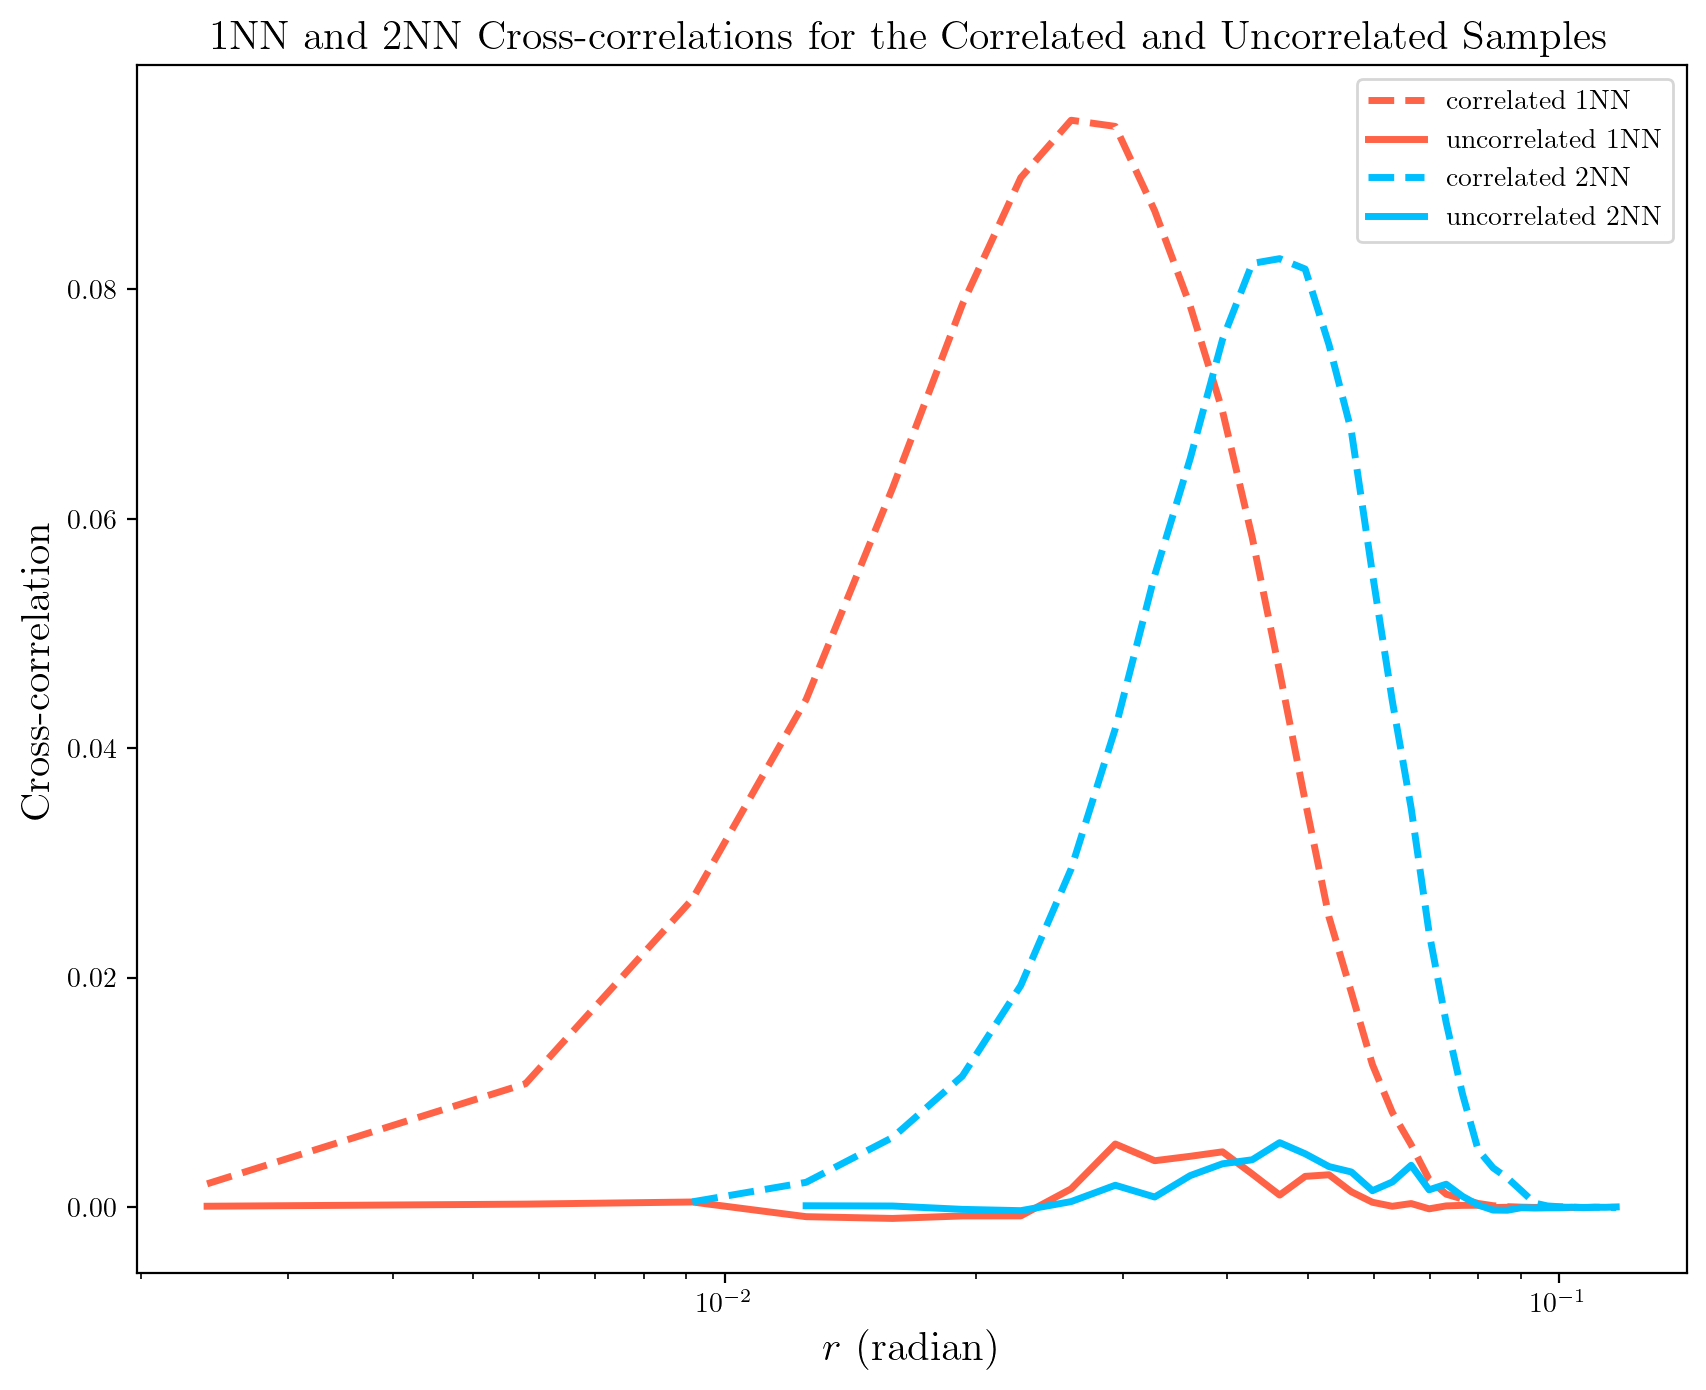

In [7]:
# plot the cross correlation for 1NN and 2NN CDFs of correlated and uncorrelated datasets
plt1 = plt.figure(figsize=(10, 8), dpi=200)
plt.title("1NN and 2NN Cross-correlations for the Correlated and Uncorrelated Samples", fontsize=15)
plt.xlabel('$r$ (radian)', fontsize=15)
plt.ylabel('Cross-correlation', fontsize=15)
plt.xscale('log') # x-axis is in log scale

plt.plot(binc, cross_correlated_1NN,  label= 'correlated 1NN', 
         linewidth=2.5,  color = "tomato", linestyle = 'dashed')
plt.plot(binc, cross_uncorrelated_1NN,  label= 'uncorrelated 1NN', 
         linewidth=2.5,  color = "tomato")

plt.plot(binc, cross_correlated_2NN,  label= 'correlated 2NN', 
         linewidth=2.5,  color = "deepskyblue", linestyle = 'dashed')
plt.plot(binc, cross_uncorrelated_2NN,  label= 'uncorrelated 2NN', 
         linewidth=2.5,  color = "deepskyblue")


plt.legend()
plt.show()

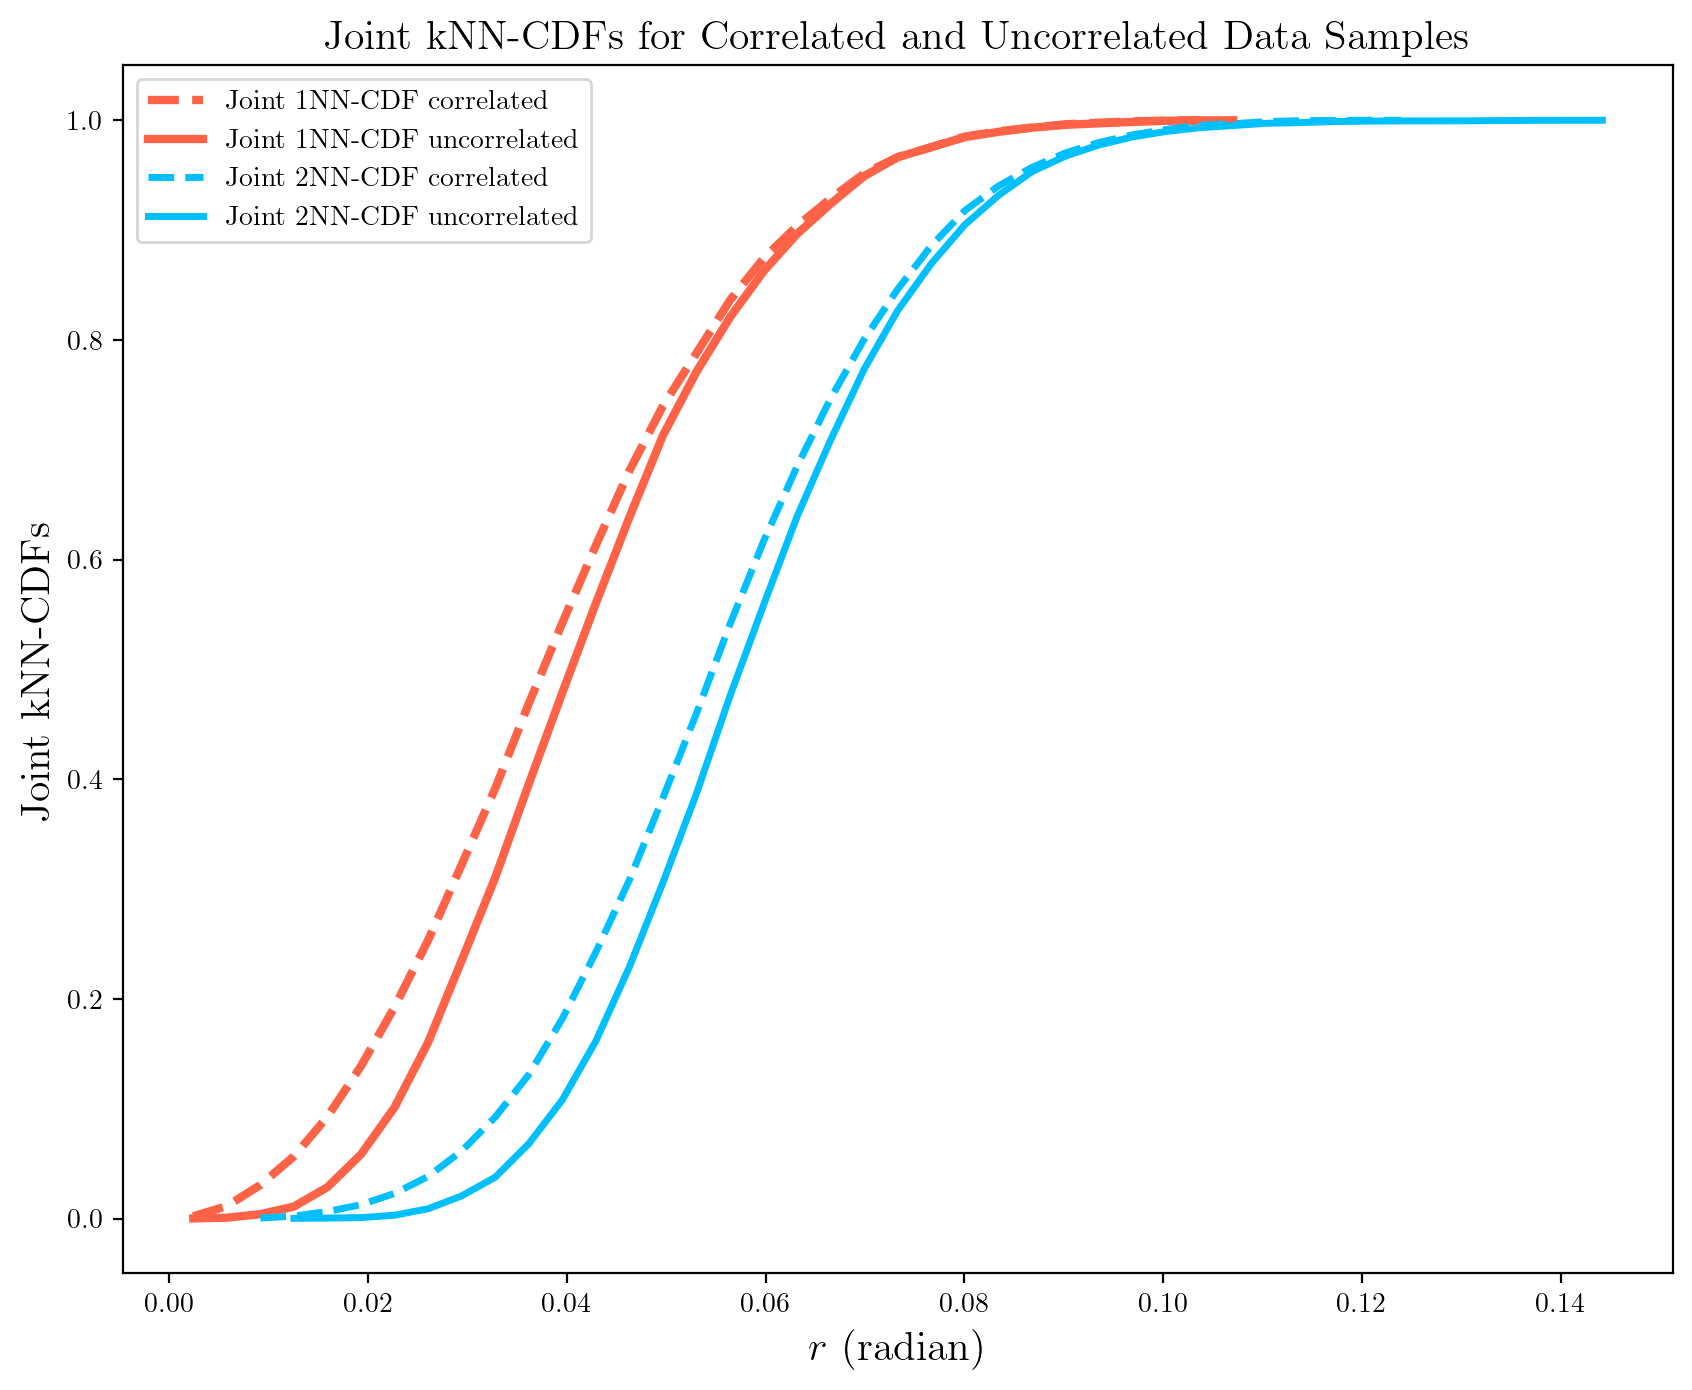

In [8]:
# Plot the first and second joint kNN-CDFs
plt2 = plt.figure(figsize=(10, 8), dpi=200)
plt.title("Joint kNN-CDFs for Correlated and Uncorrelated Data Samples", fontsize=15)
plt.xlabel('$r$  (radian)',fontsize=15)
plt.ylabel('Joint kNN-CDFs',fontsize=15)

plt.plot(binc, correlated_1NN, label= "Joint 1NN-CDF correlated"
         , linewidth=3, color = "tomato", linestyle = 'dashed')
plt.plot(binc, uncorrelated_1NN,  label= "Joint 1NN-CDF uncorrelated"
         , linewidth=3, color = "tomato")

plt.plot(binc, correlated_2NN,  label= 'Joint 2NN-CDF correlated'
         , linewidth=2.5,  color = "deepskyblue", linestyle = 'dashed')
plt.plot(binc, uncorrelated_2NN,  label= 'Joint 2NN-CDF uncorrelated'
         , linewidth=2.5,  color = "deepskyblue")

plt.legend()
plt.show()

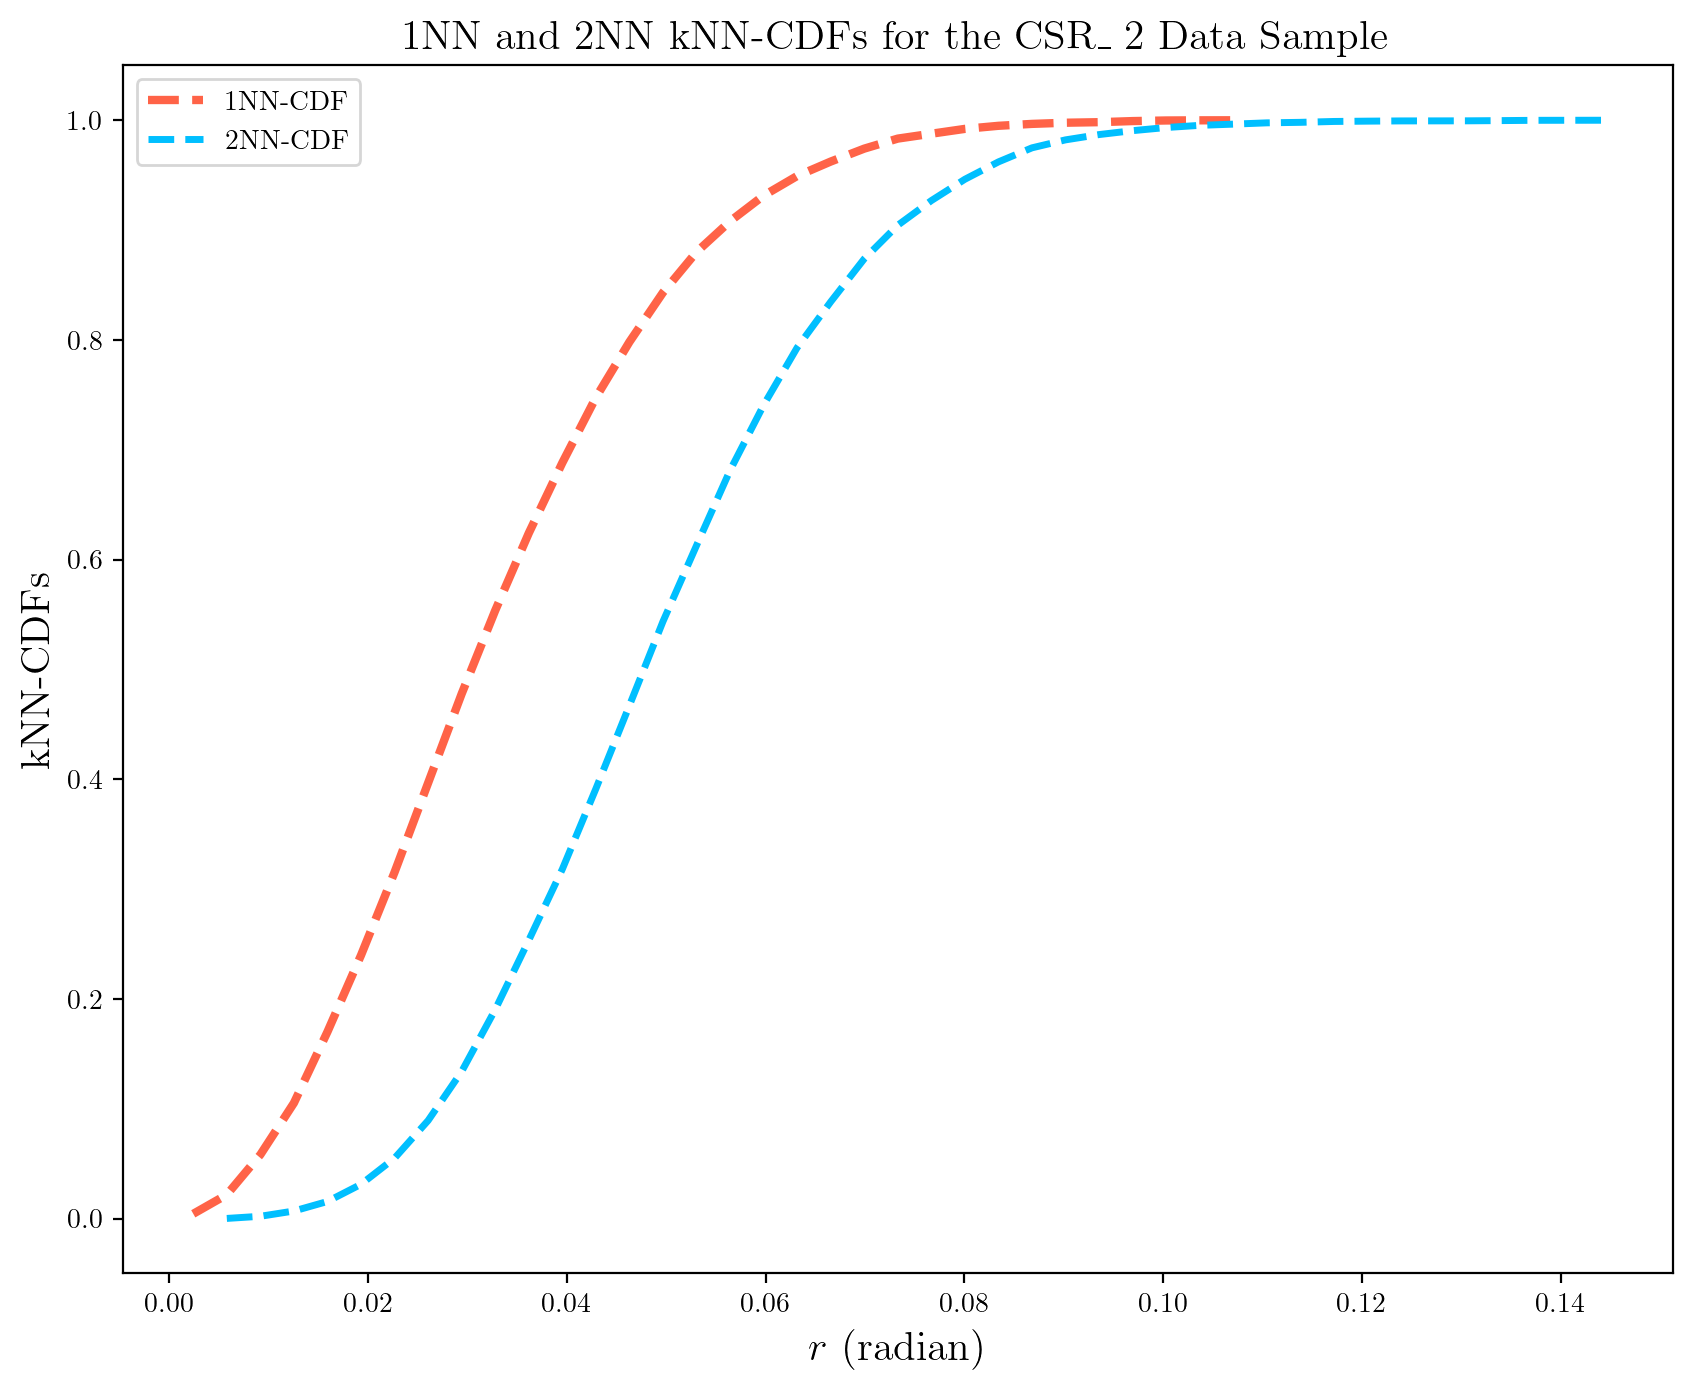

In [9]:
# Plot the first and second kNN-CDFs for the CSR_2 sample
plt2 = plt.figure(figsize=(10, 8), dpi=200)
plt.title("1NN and 2NN kNN-CDFs for the CSR_ 2 Data Sample", fontsize=15)
plt.xlabel('$r$  (radian)',fontsize=15)
plt.ylabel('kNN-CDFs',fontsize=15)

plt.plot(binc, cdf_3[0](binc), label= "1NN-CDF"
         , linewidth=3, color = "tomato", linestyle = 'dashed')

plt.plot(binc, cdf_3[1](binc),  label= '2NN-CDF'
         , linewidth=2.5,  color = "deepskyblue", linestyle = 'dashed')

plt.legend()
plt.show()